<a href="https://colab.research.google.com/github/delhian/NLP_course/blob/master/week4/seminar_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this lesson we will explore how to solve text generation task, explore new but practically old theme of tokenization and look and sampling techniques more thorougly

Our goals is to:


*   explore tokenization and modern libraries for it
*   train statistical language model
*   learn how to train text generation model
*   look how we can affect on text generation



# PART 1

You know that tokenization is a simple operation to split text into the simplest components. They can be either separate words, symbols or something more.<br>
There is a specially designed library for tokenization - `tokenizers`. It aggregates many realizations of different tokenization approaches. Futher we will explore some of them.

In [1]:
!pip install tokenizers > /dev/null
!pip install datasets > /dev/null

Let's load some data for train

In [2]:
import datasets

dataset = datasets.load_dataset('imdb')

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Byte Pair Encoding



BPE relies on a pre-tokenizer that splits the training data into words.<br>
After pre-tokenization, a set of unique words has been created and the frequency of each word it occurred in the training data has been determined. Next, BPE creates a base vocabulary consisting of all symbols that occur in the set of unique words and learns merge rules to form a new symbol from two symbols of the base vocabulary. It does so until the vocabulary has attained the desired vocabulary size. Note that the desired vocabulary size is a hyperparameter to define before training the tokenizer.


Usage of this metod looks like this

In [3]:
from tokenizers import Tokenizer, trainers
from tokenizers.models import BPE

tokenizer = Tokenizer(BPE())
trainer = trainers.BpeTrainer(
    vocab_size=30000,
    special_tokens=["<PAD>", "<BOS>", "<EOS>"],
)

You can train tokenizer from any iterable objects, file or even gzip files.

Look at the data

In [4]:
dataset['train']['text'][:5]

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
 'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything fro

In [5]:
%%time
tokenizer.train_from_iterator(dataset['train']['text'], trainer=trainer)

CPU times: user 6min 44s, sys: 5.77 s, total: 6min 50s
Wall time: 3min 42s


In [6]:
tokenizer.get_vocab()

{'Warner Bro': 26099,
 'ridiculous. ': 20030,
 'Rea': 26689,
 'for every ': 20210,
 'I would like ': 27018,
 'vision of ': 21929,
 '. Worth ': 23773,
 'architect': 21967,
 'in 196': 13582,
 'cinematograph': 2342,
 'pose ': 6378,
 'later ': 1925,
 'Down': 10176,
 'etc. ': 10625,
 'Everything ': 12319,
 'polar ': 22130,
 '.<br /><br />Oh': 25457,
 'Myers ': 24143,
 'Rachel ': 9930,
 'abled ': 20772,
 'off as ': 8434,
 'slut': 23581,
 'local': 13564,
 'Vict': 3768,
 'worth see': 10064,
 'Art ': 17017,
 'centers ': 14931,
 'Dis': 2589,
 'of course the ': 17843,
 'exteri': 21424,
 'a cent': 25372,
 'cities ': 29067,
 'songs, ': 19773,
 'ING: ': 20669,
 'vehicle': 28897,
 'robot ': 12480,
 'Earth': 7154,
 'niec': 16664,
 'remade ': 27872,
 'occur ': 14773,
 'King': 6586,
 'taken ': 2578,
 'army of ': 29618,
 'Hopkin': 16907,
 'I have never ': 24451,
 'bet': 707,
 'Que': 18500,
 'pack': 5411,
 'tim': 369,
 'impressed by ': 27713,
 'assign': 9118,
 'Gu': 2862,
 'demon': 4077,
 "DVD's ": 23295,

In [7]:
tokenizer.encode("A sequence tokenize").tokens

['A ', 'sequence ', 'to', 'ken', 'iz', 'e']

## Unigram

Unigram is a subword tokenization algorithm introduced in  [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (Kudo, 2018)](https://arxiv.org/pdf/1804.10959.pdf). In contrast to BPE or WordPiece, Unigram initializes its base vocabulary to a large number of symbols and progressively trims down each symbol to obtain a smaller vocabulary. The base vocabulary could for instance correspond to all pre-tokenized words and the most common substrings. Unigram is not used directly for any of the models in the transformers, but it’s used in conjunction with [SentencePiece](https://huggingface.co/transformers/tokenizer_summary.html#sentencepiece).

At each training step, the Unigram algorithm defines a loss (often defined as the log-likelihood) over the training data given the current vocabulary and a unigram language model. Then, for each symbol in the vocabulary, the algorithm computes how much the overall loss would increase if the symbol was to be removed from the vocabulary. Unigram then removes p (with p usually being 10% or 20%) percent of the symbols whose loss increase is the lowest, i.e. those symbols that least affect the overall loss over the training data. This process is repeated until the vocabulary has reached the desired size. The Unigram algorithm always keeps the base characters so that any word can be tokenized.

Because Unigram is not based on merge rules (in contrast to BPE and WordPiece), the algorithm has several ways of tokenizing new text after training. 

Simple usage

In [8]:
from tokenizers import models, normalizers, pre_tokenizers, decoders

tokenizer = Tokenizer(models.Unigram())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.decoders = decoders.ByteLevel()

trainer = trainers.UnigramTrainer(
    vocab_size=20000,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
    special_tokens=["<PAD>", "<BOS>", "<EOS>"],
)

tokenizer.train_from_iterator(dataset['train']['text'], trainer=trainer)

In [9]:
tokenizer.encode("A sequence to tokenize").tokens

['ĠA', 'Ġsequence', 'Ġto', 'Ġtoken', 'ize']

### Task 1 

In [10]:
batch_size =1000

# dataset['train']['text'][:batch_size]

You can train tokenizer yeilding batches to trainer. Write function that take text data from dataset variable as input and yeilds some portion of data. Each batch must be the same size and takes samples from dataset. Go trough all samples of dataset.

In [11]:
# YOUR CODE HERE
def batch_iterator(batch_size=1000):
  i = 0
  while i <= len(dataset['train']):
    print(i)
    yield dataset['train']['text'][i : i + batch_size]
    i += batch_size

In [12]:
len(dataset)

3

In [13]:
# YOUR CODE HERE
def batch_iterator(batch_size=1000):
  for i in range(0, len(dataset), batch_size):
    print(i)
    yield dataset['train'][i : i + batch_size]['text']

In [14]:
len(dataset['train']['text'])

25000

train your tokenizer using function above

In [15]:
tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=len(dataset))

0


In [16]:
assert len(tokenizer.encode("A sequence to tokenize").tokens) == 6
assert len(tokenizer.encode("A yet anoter sequence to tokenize").tokens) == 10

# PART 2

In [17]:
import tqdm

Here we will make simple statistical language model based on our little corpora.

### Task 2

Let's combine together all samples from train dataset in a single list

In [18]:
# YOUR CODE HERE
all_texts = list(dataset['train']['text'])

In [19]:
assert len(all_texts) == 25000
assert len(all_texts[5]) == 1017
assert all_texts[23].split()[7] == 'career'

To build statistical model we will use simple python dictionaries. 

In [20]:
import sys
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

model = defaultdict(lambda: defaultdict(lambda: 0))

In [21]:
# counting  
for sentence in tqdm.notebook.tqdm(all_texts):
    for w1, w2 in bigrams(sentence.split(), pad_right=True, pad_left=True):
        # print (w1, w2)
        model[(w1)][w2] += 1
 
# Convert quantities to probabilities
for w1 in model:
    total_count = float(sum(model[w1].values()))
    for w2 in model[w1]:
        model[w1][w2] /= total_count

  0%|          | 0/25000 [00:00<?, ?it/s]

### Task 3

Make model based on trigrams. As key of dictinary we get context and as value we get another dictionary. Then for each word for given context we need to count probability.

##### help

In [22]:
# 1. create dictionary
# 2. iterate through all trigrams in all_texts and count occurence of each last word with first 2 word as context
# 3. sum all possible words for given context and get probabilities for occurence of each word with corresponding context

##### Continue work


In [23]:
# list(trigrams(sentence.split(), pad_left = True, pad_right = True))

In [24]:
# YOUR CODE HERE

model = defaultdict(lambda: defaultdict(lambda: 0))

# counting  
for sentence in tqdm.notebook.tqdm(all_texts):
    for w1, w2, w3 in trigrams(sentence.split(), pad_right=True, pad_left=True):
        model[(w1, w2)] [w3] += 1
 
# Convert quantities to probabilities
for (w1, w2) in model:
    total_count = float(sum(model[(w1, w2)].values()))
    for w3 in model[(w1, w2)]:
        model[(w1, w2)][w3] /= total_count

  0%|          | 0/25000 [00:00<?, ?it/s]

In [25]:
assert max(model[('one', 'of')], key=lambda x: model[('one', 'of')][x])
assert sum(sorted(model[('A', 'classic')].values())[:-2]) < 0.87

Let's generate some text. You can set your own beginning words. Be accurate, your model can hung up in infinite loop if you set words, that don't exsist in your model

In [26]:
import random

# Beginning words for generation
text = ['This', 'film']
sentence_finished = False
 
while not sentence_finished:
  # chose random float number for boarder
  r = random.random()
  accumulator = .0

  for word in model[tuple(text[-2:])].keys():
      accumulator += model[tuple(text[-2:])][word]
      # we select only words that have a probability higher than the previously set boarder
      if accumulator >= r:
          text.append(word)
          break

  if text[-2:] == [None, None]:
      sentence_finished = True
 
print (' '.join([t for t in text if t]))

This film as much of the story of an era of the camp value has changed. You have so much that I loved that this comedy I have with this plot which is driving out of 10: awful dud.


If you want, you can make your model more applicapable by setting another values for unigram. You will use them to prevent infinite loop at the start of generation.

# Part 3

In this part we will train char level neural language model to generate Shakespeare-like sonnets. It is rather common task, but you can apply this model for any dataset.

In [1]:
!wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt

--2021-10-15 20:22:13--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119747 (117K) [text/plain]
Saving to: ‘sonnets.txt.4’

sonnets.txt.4       100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2021-10-15 20:22:13 (5.77 MB/s) - ‘sonnets.txt.4’ saved [119747/119747]



In [2]:
import time
import random
import string
import re

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

torch.backends.cudnn.deterministic = True

In [3]:
with open('sonnets.txt', 'r') as iofile:
  text = iofile.readlines()

trim some text that have unuseful information

In [4]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]

In [5]:
text[0]

'  From fairest creatures we desire increase,\n'

### Task 4

Join all the strings into one. Put result into variable `text`.

In [6]:
# YOUR CODE HERE

text = ' '.join(text)

For this task we don't have to use GPU because out training will not take so much time

In [7]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device('cpu')

TEXT_LENGTH = len(text)
TEXT_PORTION_SIZE = 200

NUM_ITER = 5000
LEARNING_RATE = 0.005
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
NUM_HIDDEN_LAYERS = 1

print('Device:', DEVICE)

Device: cpu


### Task 5

Divide the text into smaller portions. Write function that return random chunk of our text. Chunk size must be `TEXT_PORTION_SIZE`

##### help

In [8]:
# 1. Init start index for portion of text. You can randomly choose index between 0 and TEXT_LENGTH - TEXT_PORTION_SIZE
# 2. define end index
# 3. return chunk with corresponding slice

##### Continue work


In [9]:
# YOUR CODE HERE
random.seed(RANDOM_SEED)

def random_portion(textfile, TEXT_PORTION_SIZE):
    start_index = random.randint(0, len(textfile) - TEXT_PORTION_SIZE -1)
    end_index = start_index + TEXT_PORTION_SIZE
    return textfile[start_index:end_index]

Define function to translate some text into tensor with integers, that correspond to index of symbols

In [10]:
def char_to_tensor(text):
    lst = [string.printable.index(c) for c in text]
    tensor = torch.tensor(lst).long()
    return tensor

print(char_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


### Task 6

Put it together to make a function that draws random batches for training. You need to return two batches. First - random chunk of data. Second - chunk from previous step with offset by one character futher. (We need to predict next character).<br>
 Do not forget to receive tensors with integers!

In [11]:
# YOUR CODE HERE

def draw_random_sample(textfile):    
    portion = random_portion(textfile, TEXT_PORTION_SIZE + 1)
    return char_to_tensor(portion[:-1]), char_to_tensor(portion[1:])

In [12]:
inp_1, out_1 = draw_random_sample(text)

assert inp_1[5] == out_1[4]
assert len(inp_1) == TEXT_PORTION_SIZE
assert len(out_1) == TEXT_PORTION_SIZE

Now we can define our char RNN model

### Task 7

Init appropriate layers in our char rnn model. We will use LSTM as rnn block.

In [13]:
import torch.nn as nn

In [117]:
# YOUR CODE HERE
class RNN(torch.nn.Module):
    def __init__(self, input_size, embed_size,
                 hidden_size, output_size, num_layers):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(input_size, embed_size) 
        self.rnn = nn.LSTM(    
            embed_size,
            hidden_size,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(2*hidden_size, output_size)
    
    def forward(self, features, hidden_and_cell_state):
        features = features.view(1, -1)
        embedded = self.embed(features)
        
        output, hidden_and_cell_state = self.rnn(embedded, hidden_and_cell_state)
        
        output.squeeze_(0)
        output = self.fc(output)
        return output, hidden_and_cell_state
      
    def init_zero_state(self):
        init_hidden = torch.zeros(2*self.num_layers, 1, self.hidden_size).to(DEVICE)
        init_cell = torch.zeros(2*self.num_layers, 1, self.hidden_size).to(DEVICE)
        return (init_hidden, init_cell)

In [118]:
torch.manual_seed(RANDOM_SEED) # we use this for reproducibility

model = RNN(len(string.printable), EMBEDDING_DIM, HIDDEN_DIM,
            len(string.printable), NUM_HIDDEN_LAYERS)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = F.cross_entropy

Check that loss calculate correctly

In [119]:
inputs, targets = draw_random_sample(text)
outputs, _ = model(inputs[0], model.init_zero_state()) # we pass it to the model input sequence and some hidden state
print(outputs.shape, targets[0].view(1).shape)
criterion(outputs, targets[0].view(1)) # measure quality only on first predictable symbol

torch.Size([1, 100]) torch.Size([1])


tensor(4.6056, grad_fn=<NllLossBackward>)

In [120]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):

  hidden_and_cell_state = model.init_zero_state()
  prime_input = char_to_tensor(prime_str)
  predicted = prime_str

  # Use priming string to "build up" hidden state
  for p in range(len(prime_str) - 1):
    _, hidden_and_cell_state = model(prime_input[p].to(DEVICE), hidden_and_cell_state)
    inp = prime_input[-1]
    
    for p in range(predict_len):
      output, hidden_and_cell_state = model(inp.to(DEVICE), hidden_and_cell_state)
        
      # Sample from the network as a multinomial distribution
      output_dist = output.data.view(-1).div(temperature).exp()
      top_i = torch.multinomial(output_dist, 1)[0]
        
      # Add predicted character to string and use as next input
      predicted_char = string.printable[top_i]
      predicted += predicted_char
      inp = char_to_tensor(predicted_char)

  return predicted

### Task 8

Complete training loop

Time elapsed: 0.00 min
Iteration 0 | Loss 4.62


Th]ho:9	LTt3g*fL9els 

Time elapsed: 0.89 min
Iteration 200 | Loss 2.02


Thine my love out afte 

Time elapsed: 1.76 min
Iteration 400 | Loss 1.62


The to hams new whorse 

Time elapsed: 2.63 min
Iteration 600 | Loss 1.43


Thou feebbonce thou hi 

Time elapsed: 3.50 min
Iteration 800 | Loss 1.49


Thy for thou sing'd qu 



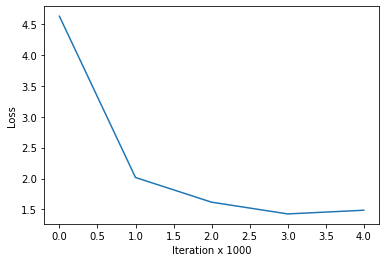

In [121]:
start_time = time.time()

loss_list = []

NUM_ITER = 1000

for iteration in range(NUM_ITER):

    hidden_and_cell_state = model.init_zero_state()
    # Fill optimizer zeroing
    
    loss = 0.
    inputs, targets = draw_random_sample(text)
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    for c in range(TEXT_PORTION_SIZE):
        outputs, hidden_and_cell_state = model(inputs[c], hidden_and_cell_state) # get prediction from model
        loss += criterion(outputs, targets[c].view(1)) 

    loss /= TEXT_PORTION_SIZE
    # run backward pass

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # update model parameters

    ### LOGGING
    with torch.no_grad():
        if iteration % 200 == 0:
            print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
            print(f'Iteration {iteration} | Loss {loss.item():.2f}\n\n')
            print(evaluate(model, 'Th', 20), '\n')
            print(50*'=')
            
            loss_list.append(loss.item())
            plt.clf()
            plt.plot(range(len(loss_list)), loss_list)
            plt.ylabel('Loss')
            plt.xlabel('Iteration x 1000')
            
plt.clf()
plt.ylabel('Loss')
plt.xlabel('Iteration x 1000')
plt.plot(range(len(loss_list)), loss_list)
plt.show()

### Task 9

run evaluation with different temperature values `[0.2, 0.5, 0.75, 0.9, 1, 2, 4]` but with common beggining phrase. Print each evaluation in cycle.

In [142]:
for T in [round(x*0.1, 1) for x in range(2, 20)]:
  print(T)
  print(evaluate(model, 'Will ', 100, T), '\n')

0.2
Will the with the with the with thy sweet where it the with the grows the with when the were where where where thou when where with the where where the with thee where the fair thee where the war where thethe where thee with the with the love where the well the summer the with the with thee when is the fwith the well thee thee thee where where the where thou love thee thee where the with the where wher 

0.3
Will her with thy sweet for thee thou make where when was where is the well when is the with thy self whethy stay.
     Then I wornters what thy well the for when the love where thy love with with thee witthe summer be where where where thee is the with the fair and thee with the sweet with the summer whthee where the sweet is thee sweet with the worth thee with thee show the with the sweet thou where  

0.4
Will the be.
     Then should fall thee from the grace summery all thou sweet where beauty self beauty withe flatt should be from shall sweet where your sweet warth be it s

### Task 10

Apply top-k sampling to evaluation function.

As a reminder

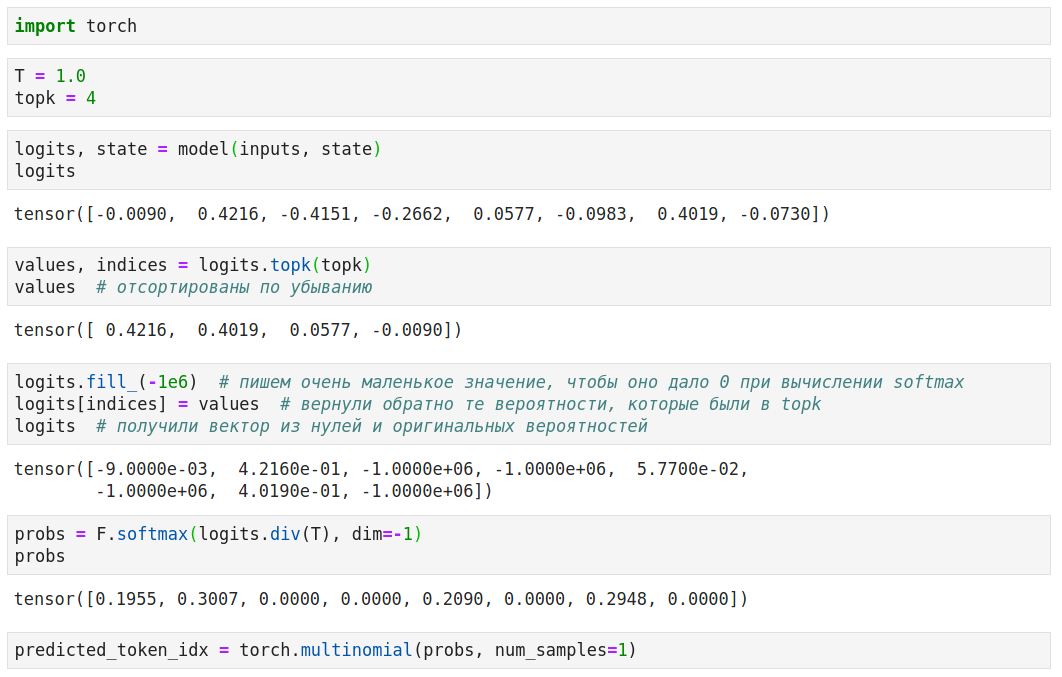

In [100]:
# YOUR CODE HERE
def evaluate_top_k(model, prime_str='A', predict_len=100, temperature=0.3, top_k=5):

  hidden_and_cell_state = model.init_zero_state()
  prime_input = char_to_tensor(prime_str)
  predicted = prime_str

  # Use priming string to "build up" hidden state
  for p in range(len(prime_str) - 1):
    _, hidden_and_cell_state = model(prime_input[p].to(DEVICE), hidden_and_cell_state)
    inp = prime_input[-1]
    
    for p in range(predict_len):
      output, hidden_and_cell_state = model(inp.to(DEVICE), hidden_and_cell_state)

      # HERE YOU CAN ADD YOUR TOP_K SAMPLING
      values, indexes = output.topk(top_k)
      output = output.fill_(-1e6)

      output[:, indexes.tolist()[0]] = values[0]
      # Sample from the network as a multinomial distribution
      output_dist = output.data.view(-1).div(temperature).exp()
      top_i = torch.multinomial(output_dist, 1)[0]
        
      # Add predicted character to string and use as next input
      predicted_char = string.printable[top_i]
      predicted += predicted_char
      inp = char_to_tensor(predicted_char)

  return predicted

In [181]:
print(evaluate_top_k(model, 'The ', predict_len=500, temperature=1.2, top_k=7), '\n')

The I be fell-bettrine ills, what its, a sener's be ire's drefiress, when it in the face till is, but weeful whon hits:
   Aloud witly my gave is to with it to grough thatt bace.
 
   XXLII
 
   But it, bress of you baty's so shalt, that what theith twen attere wenfure, love sumbed sows,
   That that besten thee, where ill, no day
     Ine is thee lim wars to be forming,
     Be wilt:
    Baty me they,
   Then worters wid it whose sence were
   I solder wastes stors to wheers: ands thy best mould stwhy face though when.
   LXIII
 
   Thee, teasented blould with hus be wnorge thou love nigh as,
     This in my lovy ill;
   But with I wors wheres.
 
   LII
 
   As wrom in and blime, art shargets wills we have with I wourst be.
 
   CXXVII
 
   But law here allow,
   Aget are though wortunguith me lives then sweet.
 
   CXXXI
 
   In this was ware sweet, all horgul gazs with hath warnty's flees, a llay bestaling well, by thy fivy
 I sobe,
   Tho sweet improv'st sueffer worth those thy was

Futher steps to approve model:
- make your network bidirectional or try greater number of layers
- try ensemble of two models, trained separetly with different parameters
- try another sampling methods